In [ ]:
!pip install pytorch-lightning -q
!pip install empath -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from torchmetrics import AUROC
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import datetime
import glob
import re
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.datasets import make_multilabel_classification
from sklearn.utils import class_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import resample
from empath import Empath

import seaborn as sns
import matplotlib.pyplot as plt

import spacy

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

path = '/content/gdrive/MyDrive/b5/'

Mounted at /content/gdrive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
lexicon = Empath()
def norm_analyze(text):
    return lexicon.analyze(text, normalize=False)

In [ ]:
len(norm_analyze("hello"))

194

In [ ]:
df1 = pd.read_csv(f'{path}Big-Five_Backstage.csv')
df = pd.read_csv(f'{path}essays/essays.csv', encoding='cp1252', delimiter=',', quotechar='"')
df = df.rename(columns={'TEXT': 'text',
                        'cEXT': 'Extraversion',
                        'cNEU': 'Neuroticism',
                        'cAGR': 'Agreeableness',
                        'cCON': 'Conscientiousness',
                        'cOPN': 'Openness'})
keys =  ['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
df[keys] = df[keys].replace({'y': 1.0, 'n': 0.0})
df

,#AUTHID,text,Extraversion,Neuroticism,Agreeableness,Conscientiousness,Openness
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0.0,1.0,1.0,0.0,1.0
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0.0,0.0,1.0,0.0,0.0
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0.0,1.0,0.0,1.0,1.0
3,1997_568848.txt,I can't believe it! It's really happening! M...,1.0,0.0,1.0,1.0,0.0
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
2463,2004_493.txt,I'm home. wanted to go to bed but remembe...,0.0,1.0,0.0,1.0,0.0
2464,2004_494.txt,Stream of consiousnesssskdj. How do you s...,1.0,1.0,0.0,0.0,1.0
2465,2004_497.txt,"It is Wednesday, December 8th and a lot has be...",0.0,0.0,1.0,0.0,0.0
2466,2004_498.txt,"Man this week has been hellish. Anyways, now i...",0.0,1.0,0.0,0.0,1.0


In [ ]:
dictionary = pd.read_csv(f'{path}dictionaries/Russian-NRC-EmoLex.txt', delimiter='\t', encoding='utf-8')

In [ ]:
dictionary

,English Word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Russian Word
0,aback,0,0,0,0,0,0,0,0,0,0,ошеломленный
1,abacus,0,0,0,0,0,0,0,0,0,1,счеты
2,abandon,0,0,0,1,0,1,0,1,0,0,покидать
3,abandoned,1,0,0,1,0,1,0,1,0,0,заброшенный
4,abandonment,1,0,0,1,0,1,0,1,1,0,оставление
...,...,...,...,...,...,...,...,...,...,...,...,...
14149,zone,0,0,0,0,0,0,0,0,0,0,зона
14150,zoo,0,0,0,0,0,0,0,0,0,0,зоопарк
14151,zoological,0,0,0,0,0,0,0,0,0,0,зоологический
14152,zoology,0,0,0,0,0,0,0,0,0,0,зоология


In [ ]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm", enable=['lemmatizer'])

In [ ]:
def lemmatize_text(text):
    clean_text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(clean_text.lower())
    return [token.lemma_ for token in doc]

def vectorize_text(text):
    rr = []
    for word in lemmatize_text(text):
      if word in s_dict:
        rr.append(s_dict[word])
    if len(rr)>0:
      t = np.array(rr).sum(axis=0)
      return t #/ len(rr)
    else:
      return np.zeros(10)

In [ ]:
dictionary['lem'] = [str(nlp(str(item).lower())[0]) for item in dictionary['English Word']]
dictionary[dictionary['lem'] != dictionary['English Word']]

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,English Word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Russian Word,lem
8465,NaN,0,0,0,0,0,0,0,0,0,0,нулевой,nan
13882,wed,0,0,0,0,0,0,0,0,0,0,мы б,we
14025,wont,0,1,0,0,0,0,0,0,0,0,не будет,wo


In [ ]:
s_dict = dict()
for idx, word in enumerate(dictionary['lem']):
    s_dict[word] = dictionary.iloc[idx, 1:11].values.tolist()

In [ ]:
texts = pd.concat([df['text'], df1['text']], ignore_index=True)
r = []
drop_i = []
for idx, text in enumerate(texts):
  print(f'\r{idx}', end='')
  r.append(vectorize_text(text))

49

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


5725

In [ ]:
texts_info = pd.DataFrame(r)
texts_info

,0,1,2,3,4,5,6,7,8,9
0,6.0,24.0,2.0,8.0,16.0,11.0,31.0,5.0,8.0,13.0
1,8.0,29.0,5.0,11.0,16.0,17.0,31.0,10.0,14.0,18.0
2,9.0,19.0,9.0,6.0,14.0,26.0,33.0,9.0,3.0,15.0
3,10.0,22.0,10.0,10.0,14.0,14.0,19.0,8.0,9.0,15.0
4,5.0,14.0,6.0,12.0,8.0,24.0,26.0,11.0,7.0,16.0
...,...,...,...,...,...,...,...,...,...,...
5721,6.0,26.0,1.0,20.0,42.0,18.0,57.0,14.0,10.0,42.0
5722,7.0,26.0,5.0,10.0,27.0,22.0,62.0,10.0,10.0,20.0
5723,6.0,32.0,4.0,20.0,38.0,23.0,55.0,19.0,17.0,37.0
5724,15.0,28.0,11.0,22.0,36.0,30.0,48.0,25.0,18.0,29.0


In [ ]:
use_predefined_encodings = False

if not use_predefined_encodings:
  labels = pd.concat([df[keys], df1[keys]], ignore_index=True)
  # texts = pd.concat([df['text'], df1['text']], ignore_index=True)
  # texts_info = pd.DataFrame(texts.apply(norm_analyze).tolist())

  row_sums = texts_info.sum(axis=1)
  texts_info = texts_info.div(row_sums, axis=0)
  nan_indices = texts_info.index[texts_info.isna().any(axis=1)]

  texts_info = texts_info.drop(index=nan_indices)
  labels = labels.drop(index=nan_indices)

  labels_tensor = torch.tensor(labels.values, dtype=torch.float).to(device)
  texts_info_tensor = torch.tensor(texts_info.values, dtype=torch.float).to(device)

  torch.save(labels_tensor, f"{path}dict/labels.pt")
  torch.save(texts_info_tensor, f"{path}dict/n_texts_info.pt")
else:
  labels_tensor = torch.load(f"{path}dict/labels.pt").to(device)
  texts_info_tensor = torch.load(f"{path}dict/n_texts_info.pt").to(device)

In [ ]:
texts_info_tensor

tensor([[0.0484, 0.1935, 0.0161,  ..., 0.0403, 0.0645, 0.1048],
        [0.0503, 0.1824, 0.0314,  ..., 0.0629, 0.0881, 0.1132],
        [0.0629, 0.1329, 0.0629,  ..., 0.0629, 0.0210, 0.1049],
        ...,
        [0.0239, 0.1275, 0.0159,  ..., 0.0757, 0.0677, 0.1474],
        [0.0573, 0.1069, 0.0420,  ..., 0.0954, 0.0687, 0.1107],
        [0.0408, 0.1224, 0.0408,  ..., 0.0612, 0.0408, 0.1020]],
       device='cuda:0')

In [ ]:
len(texts_info_tensor)

5714

In [ ]:
labels_tensor

tensor([[0., 1., 1., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 1.],
        ...,
        [0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1.],
        [0., 0., 1., 0., 1.]], device='cuda:0')

In [ ]:
len(labels_tensor)

5726

In [ ]:
def to_cpu(inputs):
  t = inputs.detach().cpu() if inputs.is_cuda else inputs.detach()
  return t.numpy().astype(float)

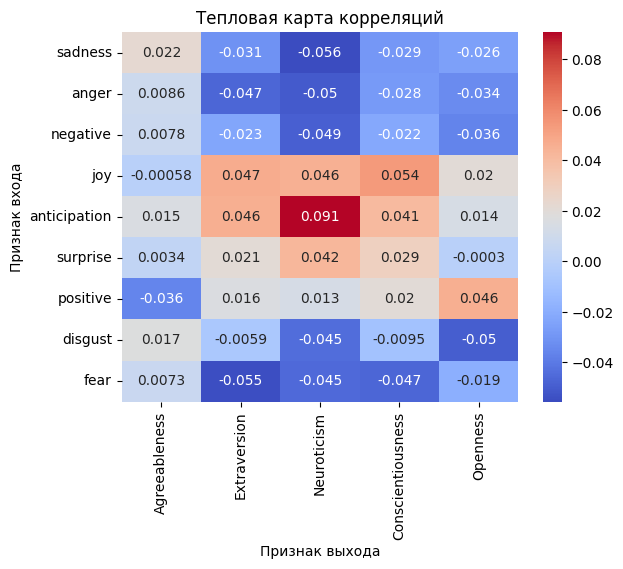

In [ ]:
idx_l = ['Extraversion', 'Agreeableness', 'Openness', 'Neuroticism', 'Conscientiousness']
# col_l = list(lexicon.cats.keys())
col_l = dictionary.columns[1:11]
correlation_matrix = pd.DataFrame(index=idx_l, columns=col_l)
for i, col1 in enumerate(labels_tensor.T):
    for j, col2 in enumerate(texts_info_tensor.T):
        corr = np.corrcoef(to_cpu(col1), to_cpu(col2))[0, 1]
        correlation_matrix.at[idx_l[i], col_l[j]] = corr

top_correlations = correlation_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()[:20].unstack()
final = correlation_matrix.loc[list(set(top_correlations.columns)), list(set(top_correlations.index.tolist()))]
final.fillna(0, inplace=True)

sns.heatmap(final.astype(float).T, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляций')
plt.xlabel('Признак выхода')
plt.ylabel('Признак входа')
plt.show()

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
le = labels_tensor.T[0:1].T
texts_info_tensor, le = undersampler.fit_resample(texts_info_tensor.cpu(), le.cpu())

train_inputs, test_inputs, train_labels, test_labels = train_test_split(torch.tensor(texts_info_tensor, dtype=torch.float).to(device), torch.tensor([le], dtype=torch.float).T.to(device), test_size=0.2, random_state=42, stratify = le)

# train_inputs = torch.tensor(train_inputs, dtype=torch.float).to(device)
# train_labels =

In [ ]:
sums = np.sum(to_cpu(train_labels), axis=0)
class_weights = len(train_labels) / sums - 1
print(class_weights)
class_weights = torch.tensor(1/class_weights, dtype=torch.float).to(device)

sums = np.sum(to_cpu(test_labels), axis=0)
class_weights = len(test_labels) / sums - 1
print(class_weights)

[1.]
[1.]


In [ ]:
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_inputs, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class MyLightningModule(pl.LightningModule):
    def __init__(self, weights):
        super().__init__()
        self.loss = torch.nn.BCELoss()
        self.l1 = torch.nn.Linear(train_inputs.shape[1], 128)
        self.l2 = torch.nn.Linear(128, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 1)
        self.s = torch.nn.Sigmoid()
       # self.auroc = AUROC(num_classes=1, task="binary")

    def forward(self, inputs):
        output = self.l1(inputs)
        output = torch.relu(output)
        output = self.l2(output)
        output = torch.relu(output)
        output = self.l3(output)
        output = torch.relu(output)
        output = self.l4(output)
        output = self.s(output)
        return output


    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels.float())

        self.log('train_loss', loss, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        loss = self.loss(outputs, labels.float())

        self.log('val_loss', loss, on_step=True)
        # roc_auc = self.auroc(outputs, labels)

        # self.log('val_roc_auc', roc_auc, on_step=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)

        mse = torch.mean((outputs - labels)**2)
        self.log('test_mse', mse, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)#, weight_decay=1e-6)

    # def configure_optimizers(self):
    #     return torch.optim.SGD(self.parameters(), lr=1e-5)

    # def configure_optimizers(self):
    #     return torch.optim.RMSprop(self.parameters(), lr=1e-5, weight_decay=1e-5)

    # def configure_optimizers(self):
    #     return torch.optim.Adagrad(self.parameters(), lr=1e-5)


In [ ]:
def get_best_checkpoint_path(checkpoint_dir):
    checkpoint_files = glob.glob(f"{checkpoint_dir}/*.ckpt")

    if not checkpoint_files:
        return None

    best_checkpoint_path = None
    best_loss = float('inf')

    for checkpoint_file in checkpoint_files:
        file_parts = checkpoint_file.split('-')
        val_loss = float(file_parts[-1][:-5].split('=')[1])

        if val_loss < best_loss:
            best_loss = val_loss
            best_checkpoint_path = checkpoint_file

    return best_checkpoint_path

In [ ]:
lModel = MyLightningModule(class_weights)
cur_path = f"{path}new/tests/"
num_epochs = 1000
trainer = pl.Trainer(
    # val_check_interval=50,
    check_val_every_n_epoch=10,
    max_epochs=num_epochs,
    log_every_n_steps=50,
    logger=pl.loggers.TensorBoardLogger(f'{cur_path}logs/', name=f'empath-net'),
    callbacks=[pl.callbacks.ModelCheckpoint(dirpath=f'{cur_path}checkpoints/', filename=f'empath-net-{{epoch}}-{{val_loss:.3f}}', monitor='val_loss', mode='min', save_top_k=1, verbose=True, enable_version_counter=True)]
)
USE_CHECKPOINT = False
if USE_CHECKPOINT:
  best_checkpoint_path = get_best_checkpoint_path(f'{cur_path}checkpoints')
  lModel = MyLightningModule.load_from_checkpoint(checkpoint_path=best_checkpoint_path)
  lModel.configure_optimizers()

trainer.fit(lModel, train_dataloaders=train_loader, val_dataloaders=test_loader)

In [ ]:
trainer.test(dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/gdrive/MyDrive/b5/new/tests/checkpoints/empath-net-epoch=629-val_loss=0.688.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/gdrive/MyDrive/b5/new/tests/checkpoints/empath-net-epoch=629-val_loss=0.688.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_mse_epoch       │    0.2472660094499588     │
└───────────────────────────┴───────────────────────────┘

[{'test_mse_epoch': 0.2472660094499588}]

In [ ]:
input = "Hi? what is your name, war, battle?"
lModel.eval()
lModel.to(device)
with torch.no_grad():
    #input_ = torch.tensor(list(norm_analyze(input).values()), dtype=torch.float).to(device)
    input_ = torch.tensor(list(vectorize_text(input)), dtype=torch.float).to(device)
    outputs = lModel(input_)
    raw_predicted_labels = outputs.float().tolist()
    predicted_labels = (outputs > 0.5).float().tolist()
    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result1 = {label_names[i]: predicted_labels[i] for i in range(len(label_names[:1]))}
    result2 = {label_names[i]: raw_predicted_labels[i] for i in range(len(label_names[:1]))}
    print(result1)
    print(result2)

{'Extroversion': 0.0}
{'Extroversion': 0.18943604826927185}


In [ ]:
lModel.eval()
lModel.to(device)
ln = 0
result_values = []
res_lab_values = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = lModel(inputs)
        ln += len(outputs)
        for idx in range(len(outputs)):
          label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
          result = {label_names[i]: (to_cpu(outputs[idx])> 0.5)[i].astype(float) for i in range(len(label_names[:1]))}
          res_lab = {label_names[i]: (to_cpu(labels[idx])> 0.5)[i].astype(float) for i in range(len(label_names[:1]))}
          result_values.append(np.array(list(result.values())))
          res_lab_values.append(np.array(list(res_lab.values())))
          # print(res_lab)
          # print(result)
          # print()
pos = np.count_nonzero(np.array(result_values) - np.array(res_lab_values) == 0)
print(ln)
print(len(test_loader.dataset))
print(pos/len(test_loader.dataset))
print(list(map(lambda x: x[0], result_values)))

948
948
0.560126582278481
[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0